In [15]:
from MNISTDataset import MNISTDataset
from CNN import CNNModel
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import transforms 

In [16]:
train_dataset = MNISTDataset(r"/home/noureldeen/Data/term 7/Intro to ML/Labs/ML_assignment2/archive/train-images.idx3-ubyte", r"/home/noureldeen/Data/term 7/Intro to ML/Labs/ML_assignment2/archive/train-labels.idx1-ubyte")
test_dataset = MNISTDataset(r"/home/noureldeen/Data/term 7/Intro to ML/Labs/ML_assignment2/archive/t10k-images.idx3-ubyte", r"/home/noureldeen/Data/term 7/Intro to ML/Labs/ML_assignment2/archive/t10k-labels.idx1-ubyte")
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

default_neurons = [128, 64]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128, 256]
neurons = [[512, 256], [384, 192], [256, 128], [128, 64],
           [512, 256, 128], [384, 192, 96], [256, 128, 64], [128, 64, 32],
           [512, 256, 128, 64], [384, 192, 96, 48], [256, 128, 64, 32], [128, 64, 32, 16]
           [512, 256, 128, 64, 32], [384, 192, 96, 48, 24], [256, 128, 64, 32, 16], [128, 64, 32, 16, 8]
           ]


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

epochs = 10
mymodel = CNNModel()
criterion =nn.CrossEntropyLoss()
optimize=torch.optim.SGD(mymodel.parameters(),lr=0.01)

best_lr_config = {"learning_rate": None, "val_accuracy": 0}
best_bs_config = {"batch_size": None, "val_accuracy": 0}

# Combined best configuration
combined_best_config = {"learning_rate": None, "batch_size": None,"val_accuracy": 0}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel.to(device)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs = inputs.view(-1, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(train_loss / total)
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(-1, 1, 28, 28)
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [38]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.view(-1, 1, 28, 28)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [36]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

Training with learning rate: 0.0001
Epoch 1/10
  Train Loss: 2.2304, Train Accuracy: 0.2019
  Val Loss: 2.1121, Val Accuracy: 0.5095
Epoch 2/10
  Train Loss: 2.0585, Train Accuracy: 0.3706
  Val Loss: 1.9476, Val Accuracy: 0.6842
Epoch 3/10
  Train Loss: 1.8965, Train Accuracy: 0.4949
  Val Loss: 1.7774, Val Accuracy: 0.7737
Epoch 4/10
  Train Loss: 1.7377, Train Accuracy: 0.5726
  Val Loss: 1.5978, Val Accuracy: 0.8292
Epoch 5/10
  Train Loss: 1.5718, Train Accuracy: 0.6400
  Val Loss: 1.4192, Val Accuracy: 0.8597
Epoch 6/10
  Train Loss: 1.4146, Train Accuracy: 0.6930
  Val Loss: 1.2531, Val Accuracy: 0.8778
Epoch 7/10
  Train Loss: 1.2681, Train Accuracy: 0.7322
  Val Loss: 1.0989, Val Accuracy: 0.8928
Epoch 8/10
  Train Loss: 1.1381, Train Accuracy: 0.7623
  Val Loss: 0.9622, Val Accuracy: 0.9053
Epoch 9/10
  Train Loss: 1.0236, Train Accuracy: 0.7887
  Val Loss: 0.8457, Val Accuracy: 0.9146
Epoch 10/10
  Train Loss: 0.9255, Train Accuracy: 0.8088
  Val Loss: 0.7513, Val Accuracy: 

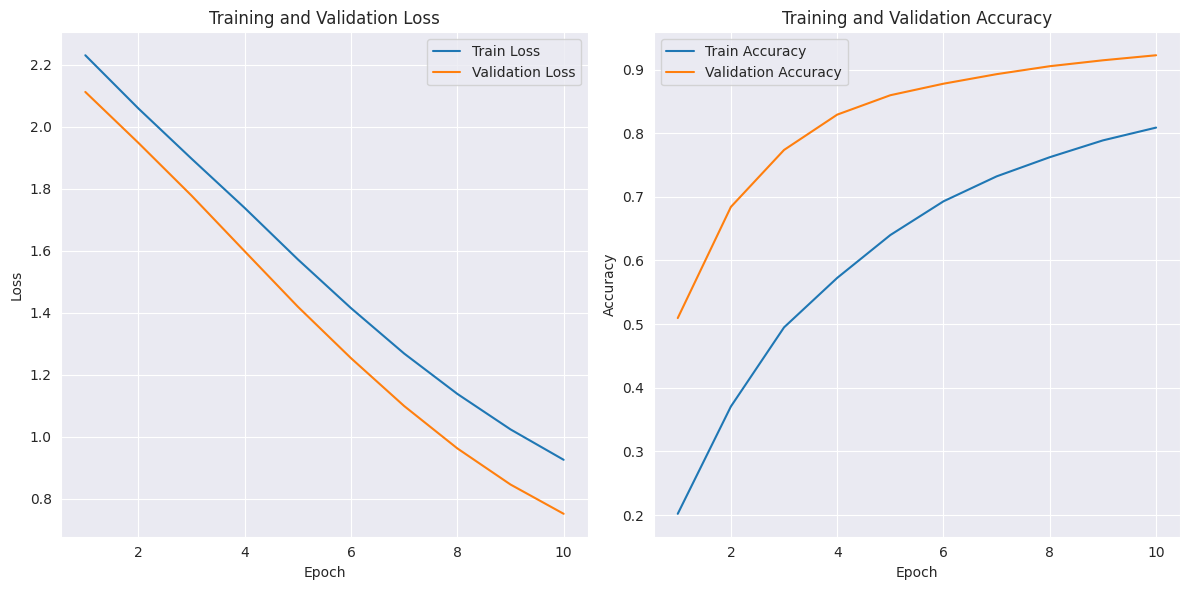

Training with learning rate: 0.001
Epoch 1/10
  Train Loss: 1.5961, Train Accuracy: 0.5601
  Val Loss: 0.8556, Val Accuracy: 0.8927
Epoch 2/10
  Train Loss: 0.6943, Train Accuracy: 0.8437
  Val Loss: 0.3716, Val Accuracy: 0.9424
Epoch 3/10
  Train Loss: 0.4164, Train Accuracy: 0.9020
  Val Loss: 0.2360, Val Accuracy: 0.9553
Epoch 4/10
  Train Loss: 0.3065, Train Accuracy: 0.9269
  Val Loss: 0.1782, Val Accuracy: 0.9600
Epoch 5/10
  Train Loss: 0.2504, Train Accuracy: 0.9362
  Val Loss: 0.1479, Val Accuracy: 0.9643
Epoch 6/10
  Train Loss: 0.2167, Train Accuracy: 0.9448
  Val Loss: 0.1288, Val Accuracy: 0.9670
Epoch 7/10
  Train Loss: 0.1894, Train Accuracy: 0.9513
  Val Loss: 0.1136, Val Accuracy: 0.9704
Epoch 8/10
  Train Loss: 0.1718, Train Accuracy: 0.9546
  Val Loss: 0.1040, Val Accuracy: 0.9730
Epoch 9/10
  Train Loss: 0.1588, Train Accuracy: 0.9586
  Val Loss: 0.0958, Val Accuracy: 0.9736
Epoch 10/10
  Train Loss: 0.1461, Train Accuracy: 0.9616
  Val Loss: 0.0896, Val Accuracy: 0

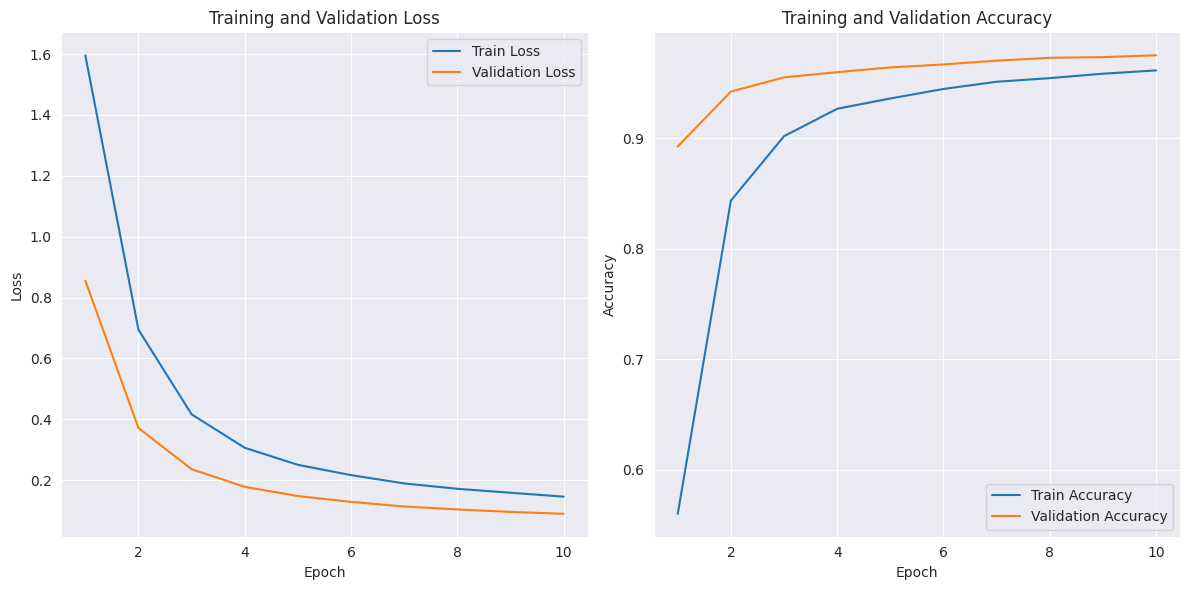

Training with learning rate: 0.01
Epoch 1/10
  Train Loss: 0.4074, Train Accuracy: 0.8918
  Val Loss: 0.0862, Val Accuracy: 0.9783
Epoch 2/10
  Train Loss: 0.1147, Train Accuracy: 0.9693
  Val Loss: 0.0620, Val Accuracy: 0.9831
Epoch 3/10
  Train Loss: 0.0822, Train Accuracy: 0.9778
  Val Loss: 0.0510, Val Accuracy: 0.9850
Epoch 4/10
  Train Loss: 0.0661, Train Accuracy: 0.9819
  Val Loss: 0.0444, Val Accuracy: 0.9864
Epoch 5/10
  Train Loss: 0.0570, Train Accuracy: 0.9844
  Val Loss: 0.0387, Val Accuracy: 0.9889
Epoch 6/10
  Train Loss: 0.0496, Train Accuracy: 0.9855
  Val Loss: 0.0391, Val Accuracy: 0.9886
Epoch 7/10
  Train Loss: 0.0430, Train Accuracy: 0.9879
  Val Loss: 0.0450, Val Accuracy: 0.9861
Epoch 8/10
  Train Loss: 0.0379, Train Accuracy: 0.9895
  Val Loss: 0.0318, Val Accuracy: 0.9908
Epoch 9/10
  Train Loss: 0.0361, Train Accuracy: 0.9898
  Val Loss: 0.0359, Val Accuracy: 0.9895
Epoch 10/10
  Train Loss: 0.0323, Train Accuracy: 0.9909
  Val Loss: 0.0320, Val Accuracy: 0.

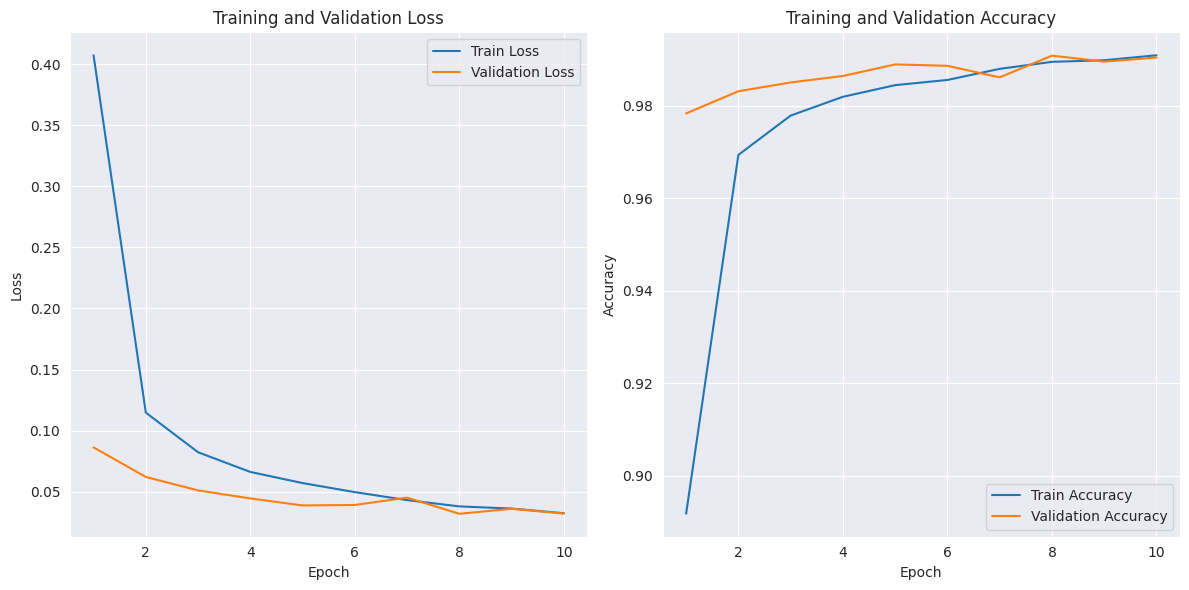

Training with learning rate: 0.1
Epoch 1/10
  Train Loss: 0.3118, Train Accuracy: 0.8992
  Val Loss: 0.0674, Val Accuracy: 0.9784
Epoch 2/10
  Train Loss: 0.0898, Train Accuracy: 0.9743
  Val Loss: 0.1489, Val Accuracy: 0.9509
Epoch 3/10
  Train Loss: 0.0662, Train Accuracy: 0.9811
  Val Loss: 0.2234, Val Accuracy: 0.9434
Epoch 4/10
  Train Loss: 0.0527, Train Accuracy: 0.9847
  Val Loss: 0.0829, Val Accuracy: 0.9762
Epoch 5/10
  Train Loss: 0.0428, Train Accuracy: 0.9878
  Val Loss: 0.0375, Val Accuracy: 0.9889
Epoch 6/10
  Train Loss: 0.0377, Train Accuracy: 0.9892
  Val Loss: 0.0296, Val Accuracy: 0.9923
Epoch 7/10
  Train Loss: 0.0324, Train Accuracy: 0.9904
  Val Loss: 0.0291, Val Accuracy: 0.9916
Epoch 8/10
  Train Loss: 0.0262, Train Accuracy: 0.9923
  Val Loss: 0.0321, Val Accuracy: 0.9926
Epoch 9/10
  Train Loss: 0.0207, Train Accuracy: 0.9935
  Val Loss: 0.0287, Val Accuracy: 0.9935
Epoch 10/10
  Train Loss: 0.0217, Train Accuracy: 0.9932
  Val Loss: 0.0320, Val Accuracy: 0.9

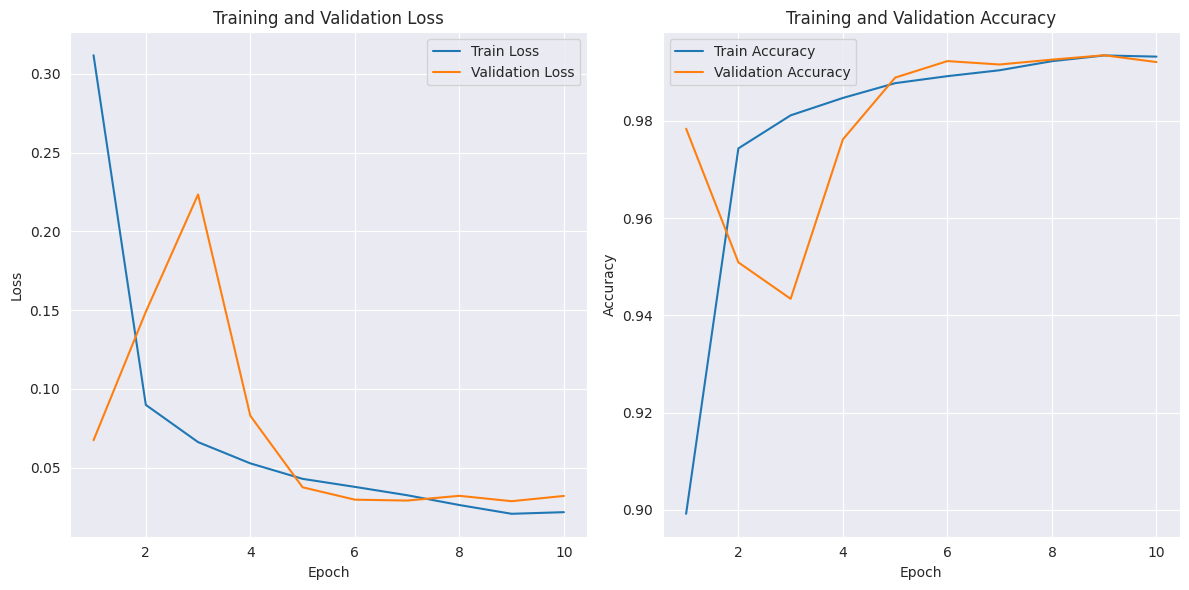

In [37]:
for lr in learning_rates:
    mymodel = CNNModel()
    criterion =nn.CrossEntropyLoss()
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.SGD(mymodel.parameters(), lr=lr)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(mymodel, train_loader, val_loader, criterion, optimizer, epochs, device)
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)
    
    max_val_accuracy = max(val_accuracies)
    
    # Update the best learning rate configuration
    if max_val_accuracy > best_lr_config["val_accuracy"]:
        best_lr_config.update({"learning_rate": lr, "val_accuracy": max_val_accuracy})
    if max_val_accuracy > combined_best_config["val_accuracy"]:
        combined_best_config.update({"learning_rate": lr, "batch_size": 64, "neurons": default_neurons, "val_accuracy": max(val_accuracies)})

Training with batch size: 32
Epoch 1/10
  Train Loss: 0.2862, Train Accuracy: 0.9220
  Val Loss: 0.0751, Val Accuracy: 0.9770
Epoch 2/10
  Train Loss: 0.0882, Train Accuracy: 0.9751
  Val Loss: 0.0554, Val Accuracy: 0.9828
Epoch 3/10
  Train Loss: 0.0643, Train Accuracy: 0.9818
  Val Loss: 0.0375, Val Accuracy: 0.9888
Epoch 4/10
  Train Loss: 0.0511, Train Accuracy: 0.9845
  Val Loss: 0.0685, Val Accuracy: 0.9774
Epoch 5/10
  Train Loss: 0.0422, Train Accuracy: 0.9875
  Val Loss: 0.0359, Val Accuracy: 0.9891
Epoch 6/10
  Train Loss: 0.0365, Train Accuracy: 0.9895
  Val Loss: 0.0325, Val Accuracy: 0.9906
Epoch 7/10
  Train Loss: 0.0323, Train Accuracy: 0.9902
  Val Loss: 0.0311, Val Accuracy: 0.9913
Epoch 8/10
  Train Loss: 0.0287, Train Accuracy: 0.9913
  Val Loss: 0.0278, Val Accuracy: 0.9922
Epoch 9/10
  Train Loss: 0.0235, Train Accuracy: 0.9929
  Val Loss: 0.0265, Val Accuracy: 0.9926
Epoch 10/10
  Train Loss: 0.0224, Train Accuracy: 0.9936
  Val Loss: 0.0271, Val Accuracy: 0.9918


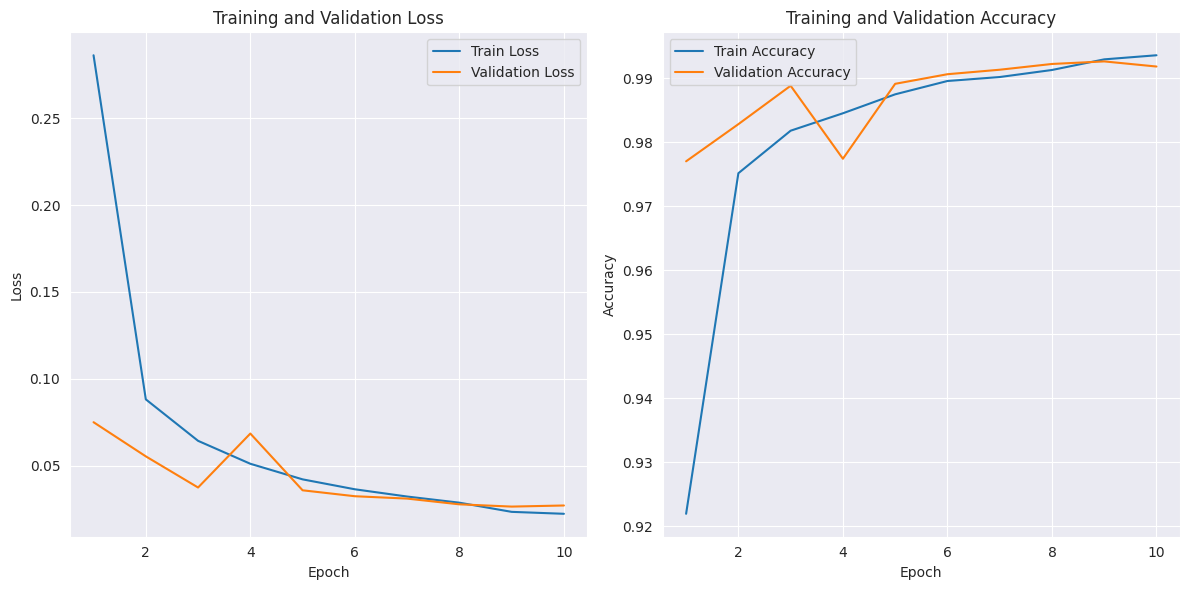

Training with batch size: 64
Epoch 1/10
  Train Loss: 0.4143, Train Accuracy: 0.8920
  Val Loss: 0.0931, Val Accuracy: 0.9730
Epoch 2/10
  Train Loss: 0.1125, Train Accuracy: 0.9686
  Val Loss: 0.0605, Val Accuracy: 0.9814
Epoch 3/10
  Train Loss: 0.0813, Train Accuracy: 0.9769
  Val Loss: 0.0483, Val Accuracy: 0.9847
Epoch 4/10
  Train Loss: 0.0667, Train Accuracy: 0.9811
  Val Loss: 0.0453, Val Accuracy: 0.9876
Epoch 5/10
  Train Loss: 0.0566, Train Accuracy: 0.9841
  Val Loss: 0.0373, Val Accuracy: 0.9891
Epoch 6/10
  Train Loss: 0.0483, Train Accuracy: 0.9862
  Val Loss: 0.0333, Val Accuracy: 0.9894
Epoch 7/10
  Train Loss: 0.0438, Train Accuracy: 0.9874
  Val Loss: 0.0346, Val Accuracy: 0.9895
Epoch 8/10
  Train Loss: 0.0376, Train Accuracy: 0.9893
  Val Loss: 0.0291, Val Accuracy: 0.9907
Epoch 9/10
  Train Loss: 0.0346, Train Accuracy: 0.9901
  Val Loss: 0.0335, Val Accuracy: 0.9895
Epoch 10/10
  Train Loss: 0.0317, Train Accuracy: 0.9911
  Val Loss: 0.0310, Val Accuracy: 0.9906


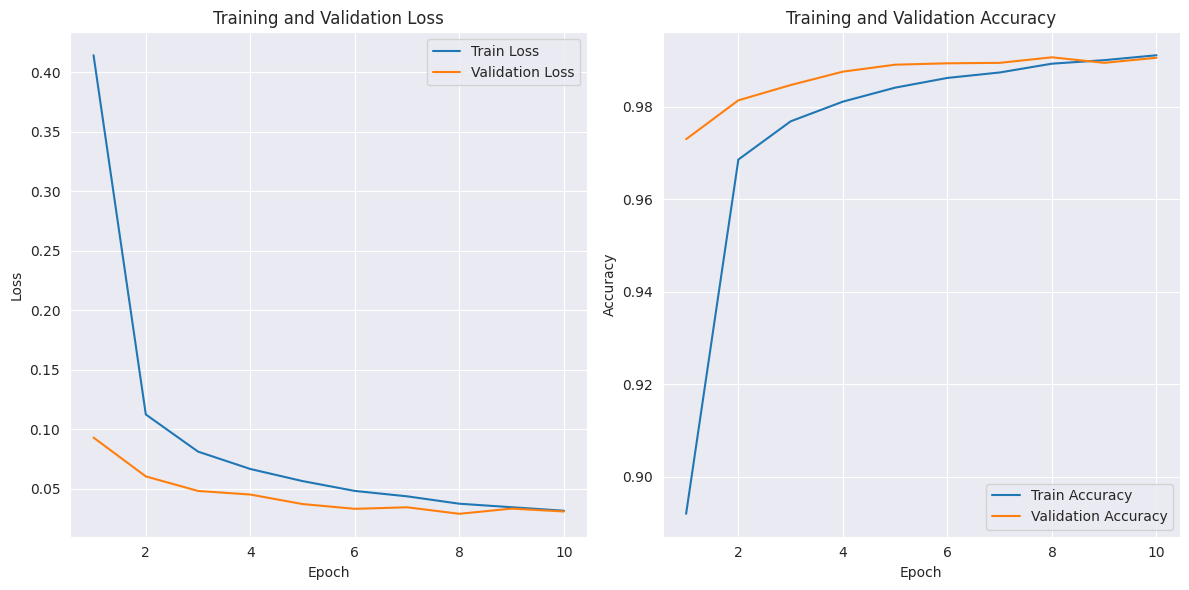

Training with batch size: 128
Epoch 1/10
  Train Loss: 0.5993, Train Accuracy: 0.8502
  Val Loss: 0.1378, Val Accuracy: 0.9650
Epoch 2/10
  Train Loss: 0.1626, Train Accuracy: 0.9575
  Val Loss: 0.0882, Val Accuracy: 0.9758
Epoch 3/10
  Train Loss: 0.1153, Train Accuracy: 0.9689
  Val Loss: 0.0669, Val Accuracy: 0.9815
Epoch 4/10
  Train Loss: 0.0913, Train Accuracy: 0.9746
  Val Loss: 0.0606, Val Accuracy: 0.9829
Epoch 5/10
  Train Loss: 0.0780, Train Accuracy: 0.9785
  Val Loss: 0.0592, Val Accuracy: 0.9818
Epoch 6/10
  Train Loss: 0.0692, Train Accuracy: 0.9811
  Val Loss: 0.0458, Val Accuracy: 0.9852
Epoch 7/10
  Train Loss: 0.0607, Train Accuracy: 0.9834
  Val Loss: 0.0428, Val Accuracy: 0.9862
Epoch 8/10
  Train Loss: 0.0544, Train Accuracy: 0.9852
  Val Loss: 0.0420, Val Accuracy: 0.9875
Epoch 9/10
  Train Loss: 0.0527, Train Accuracy: 0.9852
  Val Loss: 0.0386, Val Accuracy: 0.9888
Epoch 10/10
  Train Loss: 0.0458, Train Accuracy: 0.9872
  Val Loss: 0.0364, Val Accuracy: 0.9880

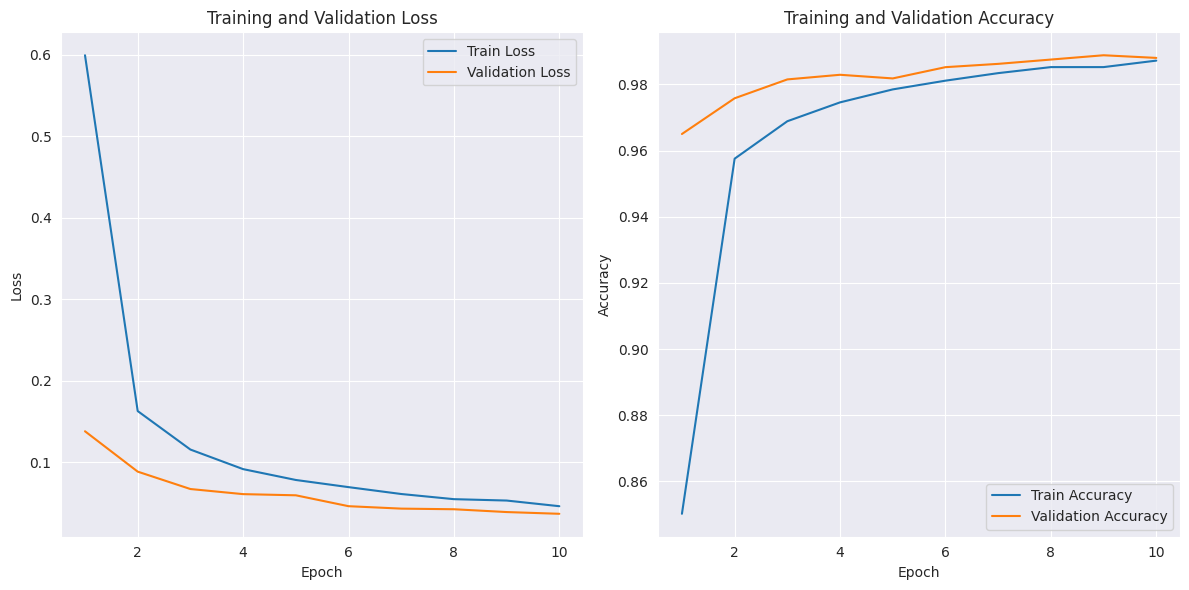

Training with batch size: 256
Epoch 1/10
  Train Loss: 0.8653, Train Accuracy: 0.7832
  Val Loss: 0.2586, Val Accuracy: 0.9479
Epoch 2/10
  Train Loss: 0.2714, Train Accuracy: 0.9320
  Val Loss: 0.1466, Val Accuracy: 0.9636
Epoch 3/10
  Train Loss: 0.1846, Train Accuracy: 0.9525
  Val Loss: 0.1091, Val Accuracy: 0.9695
Epoch 4/10
  Train Loss: 0.1463, Train Accuracy: 0.9617
  Val Loss: 0.0908, Val Accuracy: 0.9750
Epoch 5/10
  Train Loss: 0.1249, Train Accuracy: 0.9667
  Val Loss: 0.0781, Val Accuracy: 0.9778
Epoch 6/10
  Train Loss: 0.1104, Train Accuracy: 0.9693
  Val Loss: 0.0700, Val Accuracy: 0.9805
Epoch 7/10
  Train Loss: 0.0985, Train Accuracy: 0.9736
  Val Loss: 0.0663, Val Accuracy: 0.9809
Epoch 8/10
  Train Loss: 0.0878, Train Accuracy: 0.9765
  Val Loss: 0.0584, Val Accuracy: 0.9832
Epoch 9/10
  Train Loss: 0.0836, Train Accuracy: 0.9770
  Val Loss: 0.0575, Val Accuracy: 0.9824
Epoch 10/10
  Train Loss: 0.0770, Train Accuracy: 0.9781
  Val Loss: 0.0559, Val Accuracy: 0.9830

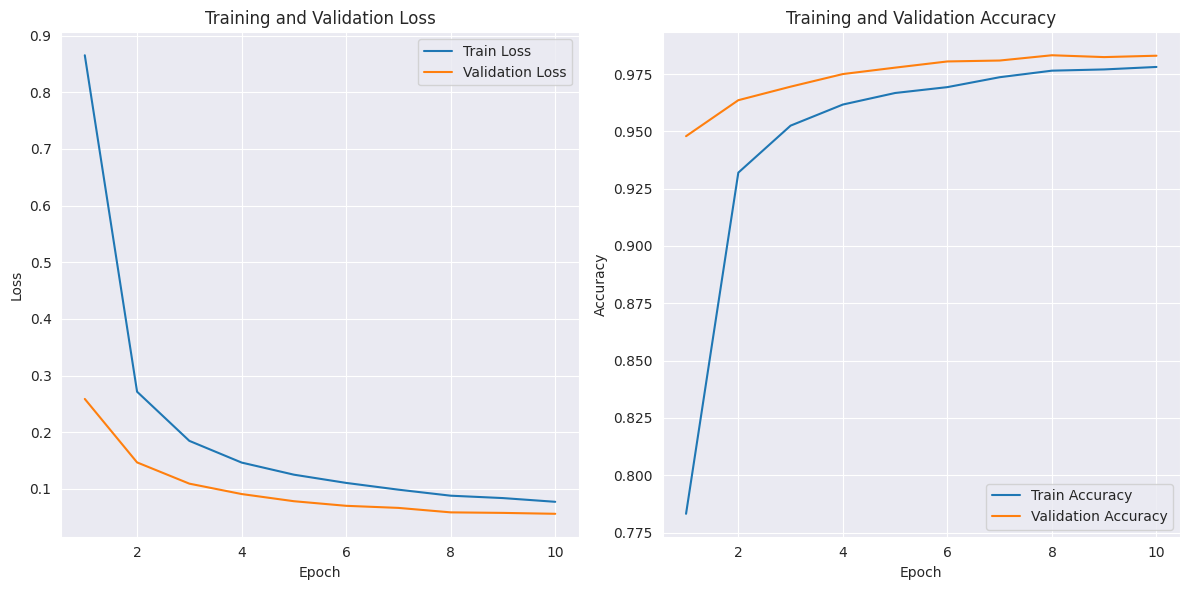

In [39]:
for bs in batch_sizes:
    mymodel = CNNModel()
    criterion =nn.CrossEntropyLoss()
    optimize=torch.optim.SGD(mymodel.parameters(),lr=0.01)
    print(f"Training with batch size: {bs}")
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(mymodel, train_loader, val_loader, criterion, optimize, epochs, device)
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)
    
    max_val_accuracy = max(val_accuracies)
    
    # Update the best batch size configuration
    if max_val_accuracy > best_bs_config["val_accuracy"]:
        best_bs_config.update({"batch_size": bs, "val_accuracy": max_val_accuracy})
    if max_val_accuracy > combined_best_config["val_accuracy"]:
        combined_best_config.update({"learning_rate": 0.01, "batch_size": bs, "neurons": default_neurons, "val_accuracy": max(val_accuracies)})

In [41]:

# Re-train and evaluate the final combined best model
print("\nTraining and evaluating the best combined model on test set...")
train_loader = DataLoader(train_dataset, batch_size=combined_best_config["batch_size"], shuffle=True)
mymodel = CNNModel()  # Initialize the best model
optimizer = torch.optim.SGD(mymodel.parameters(), lr=combined_best_config["learning_rate"])
train_model(mymodel, train_loader, val_loader, criterion, optimizer, epochs, device)
evaluate_model(mymodel, test_loader)

# Print the best configurations
print("\nBest Configurations:")
print(f"  Best Learning Rate: {best_lr_config['learning_rate']} (Validation Accuracy: {best_lr_config['val_accuracy']:.4f})")
print(f"  Best Batch Size: {best_bs_config['batch_size']} (Validation Accuracy: {best_bs_config['val_accuracy']:.4f})")
print(f"  Combined Best Configuration: {combined_best_config}")


Training and evaluating the best combined model on test set...


KeyboardInterrupt: 